# Miniprojeto 1 - Redes Neurais 2025.2

Aplicação do Multilayer Perceptron (MLP) e da Rede Neural Convolucional (CNN) na base de dados CIFAR10.

* Isaac Manoel Teixeira da Silva
(imts2@cin.ufpe.br)
* Lucas Emmanuel Soares de Araujo Francisco
(lesaf@cin.ufpe.br)
* Marcelo Henrique Alexandre Barreiros
(mhab@cin.ufpe.br)
* Rodrigo Rocha Moura (rrm2@cin.ufpe.br)

## Importações e Bibliotecas

- **`import torch`**  
Biblioteca principal de *deep learning* que fornece tensores, operações matemáticas otimizadas e suporte a GPU. É a base para definir e treinar redes neurais.  

- **`import torchvision`**  
Conjunto de ferramentas para visão computacional no PyTorch. Inclui datasets prontos (como CIFAR-10), modelos pré-treinados e utilidades para processamento de imagens.  

- **`import torch.nn as nn`**  
Módulo que contém camadas e funções para construir redes neurais (como `Linear`, `ReLU`, `CrossEntropyLoss`). Facilita a definição de arquiteturas MLP, CNN etc.

- **`import torchvision.transforms as transforms`**  
Fornece transformações de dados (como normalização, rotação, *toTensor*). Essencial para pré-processar e aumentar o dataset antes do treino.

- **`from torch.utils.data import random_split`**  
Divide um dataset em subconjuntos de tamanho especificado.
Ela escolhe os elementos de forma aleatória, garantindo que não haja sobreposição.

- **`from torch.utils.data import DataLoader`**  
O DataLoader cria lotes (batches) do dataset, embaralha os dados se desejado e gerencia múltiplos workers para leitura eficiente. Ele transforma o dataset em um iterador prático para usar em loops de treino/validação.

- **`import torch.optim as optim`**  
Importando o submódulo que contém os otimizadores (SGD, Adam, RMSprop etc) do PyTorch.

- **`import optuna`**  
O Optuna é uma biblioteca de otimização de hiperparâmetros.
Ele testa combinações diferentes de parâmetros e encontra automaticamente as que dão melhor desempenho no modelo.  

- **`import optuna.visualization as vis`**  
Submódulo da biblioteca Optuna que traz visualizações das trials executadas.

- **`import matplotlib.pyplot as plt`**  
Biblioteca para visualização de gráficos e imagens. Usada para inspecionar exemplos do dataset e monitorar métricas do treino.  

- **`import numpy as np`**  
Biblioteca para operações numéricas com arrays. Geralmente usada em conjunto com PyTorch para manipulação e conversão de dados.  

- **`from sklearn import metrics`**  
Ferramentas para avaliação de modelos: cálculo de acurácia, precisão, recall, F1-score, matrizes de confusão etc.  

- **`from tqdm import tqdm`**  
Cria barras de progresso em loops. Muito útil para visualizar o andamento do treinamento e validação de modelos.  

- **`from tqdm import tqdm`**  
Cria barras de progresso em loops. Muito útil para visualizar o andamento do treinamento e validação de modelos.  


In [ ]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install plotly

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

import optuna
import optuna.visualization as vis

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Base de dados

### Sobre o **CIFAR-10**

É um dos datasets mais usados em visão computacional. Contém **60.000 imagens coloridas (32×32 pixels, 3 canais RGB)** divididas em **10 classes**:  
- avião, carro, pássaro, gato, cervo, cachorro, sapo, cavalo, navio, caminhão.  

Divisão dos dados:  
- **50.000 imagens para treino**  
- **10.000 imagens para teste**  

Por ser pequeno e padronizado, é ideal para experimentar modelos como MLPs e CNNs.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


100%|██████████| 170M/170M [02:53<00:00, 984kB/s]


Explicação do código acima

- **`transform = transforms.Compose([...])`**  
Cria um pipeline de transformações que será aplicado em cada imagem do dataset. Aqui ele converte a imagem em tensor e depois normaliza os valores dos pixels.  

- **`transforms.ToTensor()`**  
Converte imagens do formato PIL ou NumPy para `torch.Tensor`, reescalando automaticamente os pixels de `[0, 255]` para `[0, 1]`.  

- **`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`**  
Normaliza cada canal RGB da imagem para ter média `0` e desvio padrão `1`, mas centralizado em torno de `-1 a 1`. Isso ajuda no treinamento da rede neural.  

- **`train_dataset = torchvision.datasets.CIFAR10(...)`**  
Baixa (se não existir em `./data`) e carrega o conjunto de treino da base CIFAR10, aplicando as transformações definidas.  

- **`root='./data'`**  
Define a pasta onde o dataset será armazenado ou lido.  

- **`train=True`**  
Especifica que queremos o conjunto de **treinamento**.  

- **`download=True`**  
Permite que o dataset seja baixado automaticamente caso não exista localmente.  

- **`transform=transform`**  
Aplica as transformações definidas (`ToTensor` + `Normalize`) a cada amostra do dataset.  

- **`test_dataset = torchvision.datasets.CIFAR10(...)`**  
Carrega o conjunto de **teste**, com os mesmos parâmetros, mas agora `train=False` para não misturar com treino.

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

Explicação do código acima

- **`train_size = int(0.8 * len(train_dataset))`** e **`val_size = len(train_dataset) - train_size`**  
Essas linhas definem a proporção dos dados. A primeira calcula que 80% do conjunto de treino será usado para o treinamento de fato (train_size). A segunda calcula o restante, ou seja, os 20% que serão usados para a validação (val_size). A validação é essencial para checar se o modelo está aprendendo corretamente e evitar o overfitting.

- **`train_subset, val_subset = random_split(train_dataset, [train_size, val_size])`**  
A função random_split divide o conjunto de dados original (train_dataset) em dois subconjuntos menores (train_subset e val_subset), usando os tamanhos definidos acima. O "random" no nome da função é importante: ele garante que a divisão seja aleatória, distribuindo os dados de maneira imparcial entre os dois subconjuntos.

In [ ]:
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Tamanho do dataset de treino: {len(train_subset)}")
print(f"Tamanho do dataset de validação: {len(val_subset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

Tamanho do dataset de treino: 40000
Tamanho do dataset de validação: 10000
Tamanho do dataset de teste: 10000


Explicação do código acima

- **`batch_size = 64`**  
Aqui é definido o tamanho do lote (batch). O modelo não processa todo o dataset de uma vez. Em vez disso, ele é alimentado com pequenos grupos de 64 imagens por vez. Isso é mais eficiente para o uso da memória (principalmente da GPU) e ajuda a estabilizar o processo de treinamento.

- **`train_loader = DataLoader(...)`**, **`val_loader = DataLoader(...)`** e **`test_loader = DataLoader(...)`**  
Os DataLoaders são a forma do PyTorch de carregar os dados. Eles transformam os conjuntos de dados em iteráveis, o que facilita o uso em loops de treinamento.

  - **`train_loader`**: Usa o train_subset com shuffle=True (embaralhando os dados a cada rodada para evitar que o modelo aprenda a ordem das imagens) e num_workers=2 (usando dois processos para carregar dados em paralelo, o que acelera o processo).

  - **`val_loader`**: Usa o val_subset. O shuffle aqui é False porque a ordem dos dados de validação não é relevante; só precisa avaliar a performance do modelo.

  - **`test_loader`**: Usa o test_dataset, que é um conjunto de dados completamente novo e não visto pelo modelo durante o treinamento. Ele serve para uma avaliação final e justa da performance do modelo. O shuffle também é False.

## Experimentos - MLP

Uma vez que definimos o dataset e organizamos os subsets e batches, prosseguimos para a definição dos hiperparâmetros do MLP.


- **Número de camadas (profundidade)**  
  Determina a capacidade de representação: mais camadas permitem aprender funções mais complexas e hierarquias de características, mas aumentam risco de overfitting e tornam o treino mais difícil (vanishing/exploding gradients). Em PyTorch (`torch`, `torch.nn`) você define isso empilhando camadas `nn.Linear`/`nn.Module`; vamos monitoriar com `tqdm` e métricas (`sklearn.metrics`) para ver se ganhar profundidade realmente melhora validação.

- **Número de neurônios por camada (largura)**  
  Controla quantos parâmetros a rede tem para modelar padrões; mais neurônios aumentam capacidade e risco de overfitting e custo computacional.

- **Taxa de aprendizagem (learning rate)**  
  É um dos hiperparâmetros mais críticos: define o tamanho dos passos do otimizador. Taxa muito alta causa divergência; muito baixa torna o treino lento e pode prender em mínimos locais.

- **Função de ativação**  
  Introduz não-linearidade necessária para aprender mapeamentos complexos; escolhas comuns: ReLU (rápida, evita saturação em muitos casos), LeakyReLU, tanh, sigmoid. As ativations são camadas em `torch.nn` (ex.: `nn.ReLU()`); a escolha afeta convergência e estabilidade do gradiente.

- **Regularização (L1/L2, weight decay, early stopping)**  
  Reduz overfitting penalizando pesos grandes (L1/L2) ou parando treino quando a validação para de melhorar. Em PyTorch `weight_decay` no otimizador implementa L2. Regularização bem calibrada melhora generalização sem sacrificar capacidade.

- **Algoritmo de aprendizagem (otimizador)**  
  Determina como os gradientes atualizam os pesos: SGD, SGD com momentum, Adam, RMSprop etc. Cada um tem sensibilidade distinta à taxa de aprendizagem e ao ruído do gradiente; por exemplo, Adam frequentemente converge mais rápido enquanto SGD com momentum pode generalizar melhor.

- **Dropout**  
  Técnica simples de regularização que desliga aleatoriamente neurônios durante o treino, forçando a rede a não depender excessivamente de unidades específicas. Ajuda a reduzir overfitting e melhora robustez; em PyTorch é `nn.Dropout(p)`.

A seguir vamos realizar dois experimentos antes de partirmos para o Optuna. Esse experimentos alteram a profundidade e a largura do MLP.

- Experimento 1:
  - **`hidden_layer_1`**: 64 neurônios
  - **`hidden_layer_2`**: 128 neurônios

- Experimento 2:
  - **`hidden_layer_1`**: 256 neurônios
  - **`hidden_layer_2`**: 512 neurônios
  - **`hidden_layer_3`**: 256 neurônios
  - **`hidden_layer_4`**: 128 neurônios
  - **`hidden_layer_5`**: 64 neurônios

- Hiperparâmetros iguais para ambos os experimentos:
  - **`learning_rate`**: 0.001
  - **`activation_function`**: ReLU
  - **`weight_decay`** (regularização): 1e-4
  - **`optimizer`** (algoritmo de aprendizagem): Adam
  - **`drop_out`**: 0.3

Experimento 1

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, num_classes, activation_function, dropout_rate):
    super(MLP,self).__init__()
    self.activation_function = activation_function
    self.fc_input = nn.Linear(input_size, 64)
    self.fc_hidden1 = nn.Linear(64, 128)
    self.fc_hidden2 = nn.Linear(128, 64)
    self.dropout = nn.Dropout(dropout_rate)
    self.fc_output = nn.Linear(64, num_classes)

  def forward(self,x):
    x = self.activation_function(self.fc_input(x))
    x = self.dropout(x)
    x = self.activation_function(self.fc_hidden1(x))
    x = self.dropout(x)
    x = self.activation_function(self.fc_hidden2(x))
    x = self.dropout(x)
    x = self.fc_output(x)
    return x

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

input_size = 32*32*3
num_classes = 10
learning_rate = 0.001
num_epochs = 20
batch_size = 16
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()
dropout_rate = 0.3
weight_decay = 1e-4
mlp = MLP(input_size=input_size, num_classes=num_classes, activation_function=activation_function, dropout_rate=dropout_rate)
mlp = mlp.to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,32*32*3).to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = mlp(images)

    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

  if epoch_loss < best_loss:
    best_loss = epoch_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

mlp.eval()
predictions = []
labels = []
for images, label in test_loader:
  images = images.view(-1,32*32*3).to(device)
  label = label.to(device)
  output = mlp(images)
  _, predicted = torch.max(output,1)
  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

  5%|▌         | 1/20 [00:12<04:05, 12.94s/it]

Epoch 1 average loss: 1.9031


 10%|█         | 2/20 [00:27<04:13, 14.10s/it]

Epoch 2 average loss: 1.7611


 15%|█▌        | 3/20 [00:38<03:29, 12.33s/it]

Epoch 3 average loss: 1.7022


 20%|██        | 4/20 [00:48<03:05, 11.61s/it]

Epoch 4 average loss: 1.6640


 25%|██▌       | 5/20 [00:58<02:46, 11.10s/it]

Epoch 5 average loss: 1.6367


 30%|███       | 6/20 [01:07<02:26, 10.45s/it]

Epoch 6 average loss: 1.6126


 35%|███▌      | 7/20 [01:17<02:13, 10.30s/it]

Epoch 7 average loss: 1.5863


 40%|████      | 8/20 [01:27<02:02, 10.19s/it]

Epoch 8 average loss: 1.5704


 45%|████▌     | 9/20 [01:37<01:50, 10.07s/it]

Epoch 9 average loss: 1.5552


 50%|█████     | 10/20 [01:49<01:45, 10.53s/it]

Epoch 10 average loss: 1.5413


 55%|█████▌    | 11/20 [01:58<01:30, 10.09s/it]

Epoch 11 average loss: 1.5351


 60%|██████    | 12/20 [02:08<01:20, 10.07s/it]

Epoch 12 average loss: 1.5274


 65%|██████▌   | 13/20 [02:18<01:10, 10.05s/it]

Epoch 13 average loss: 1.5154


 70%|███████   | 14/20 [02:28<01:00, 10.01s/it]

Epoch 14 average loss: 1.5115


 75%|███████▌  | 15/20 [02:37<00:48,  9.69s/it]

Epoch 15 average loss: 1.5040


 80%|████████  | 16/20 [02:47<00:39,  9.76s/it]

Epoch 16 average loss: 1.4972


 85%|████████▌ | 17/20 [02:57<00:29,  9.81s/it]

Epoch 17 average loss: 1.4941


 90%|█████████ | 18/20 [03:06<00:19,  9.83s/it]

Epoch 18 average loss: 1.4879


 95%|█████████▌| 19/20 [03:16<00:09,  9.71s/it]

Epoch 19 average loss: 1.4819


100%|██████████| 20/20 [03:25<00:00, 10.29s/it]

Epoch 20 average loss: 1.4703


Scores of your model
 {'accuracy': 0.492, 'balanced_accuracy': np.float64(0.492), 'precision': 0.4894711736993012, 'recall': 0.492, 'f1_score': 0.48376359614768005}


Experimento 2

In [ ]:
class MLPEnhanced(nn.Module):
    def __init__(self, input_size, num_classes, activation_function, dropout_rate=0.3):
        super(MLPEnhanced, self).__init__()
        self.activation = activation_function

        def block(in_f, out_f):
            return nn.Sequential(
                nn.Linear(in_f, out_f),
                nn.BatchNorm1d(out_f),
                self.activation,
                nn.Dropout(dropout_rate)
            )

        self.fc1 = block(input_size, 256)
        self.fc2 = block(256, 512)
        self.fc3 = block(512, 256)
        self.fc4 = block(256, 128)
        self.fc5 = block(128, 64)

        self.output = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.output(x)
        return x


input_size = 32*32*3
num_classes = 10
learning_rate = 0.001
num_epochs = 20
batch_size = 16
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

dropout_rate = 0.3
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = MLPEnhanced(
    input_size=input_size,
    num_classes=num_classes,
    activation_function=activation_function,
    dropout_rate=dropout_rate
).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

    epoch_loss /= len(train_loader)
    tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break

mlp.eval()
predictions = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.view(-1, input_size).to(device)
        label = label.to(device)
        output = mlp(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

  5%|▌         | 1/20 [00:11<03:31, 11.11s/it]

Epoch 1 average loss: 2.0597


 10%|█         | 2/20 [00:21<03:17, 10.98s/it]

Epoch 2 average loss: 1.7752


 15%|█▌        | 3/20 [00:33<03:14, 11.44s/it]

Epoch 3 average loss: 1.6838


 20%|██        | 4/20 [00:44<02:56, 11.02s/it]

Epoch 4 average loss: 1.6243


 25%|██▌       | 5/20 [00:54<02:42, 10.85s/it]

Epoch 5 average loss: 1.5879


 30%|███       | 6/20 [01:05<02:31, 10.85s/it]

Epoch 6 average loss: 1.5508


 35%|███▌      | 7/20 [01:16<02:22, 10.93s/it]

Epoch 7 average loss: 1.5178


 40%|████      | 8/20 [01:27<02:10, 10.91s/it]

Epoch 8 average loss: 1.4979


 45%|████▌     | 9/20 [01:38<01:59, 10.91s/it]

Epoch 9 average loss: 1.4796


 50%|█████     | 10/20 [01:49<01:49, 11.00s/it]

Epoch 10 average loss: 1.4581


 55%|█████▌    | 11/20 [02:00<01:36, 10.75s/it]

Epoch 11 average loss: 1.4455


 60%|██████    | 12/20 [02:10<01:25, 10.72s/it]

Epoch 12 average loss: 1.4313


 65%|██████▌   | 13/20 [02:21<01:15, 10.79s/it]

Epoch 13 average loss: 1.4194


 70%|███████   | 14/20 [02:32<01:04, 10.83s/it]

Epoch 14 average loss: 1.4093


 75%|███████▌  | 15/20 [02:43<00:54, 10.90s/it]

Epoch 15 average loss: 1.3955


 80%|████████  | 16/20 [02:54<00:43, 10.94s/it]

Epoch 16 average loss: 1.3818


 85%|████████▌ | 17/20 [03:05<00:32, 10.93s/it]

Epoch 17 average loss: 1.3717


 90%|█████████ | 18/20 [03:15<00:21, 10.65s/it]

Epoch 18 average loss: 1.3651


 95%|█████████▌| 19/20 [03:26<00:10, 10.62s/it]

Epoch 19 average loss: 1.3525


100%|██████████| 20/20 [03:37<00:00, 10.90s/it]

Epoch 20 average loss: 1.3465


Scores of your model
 {'accuracy': 0.5376, 'balanced_accuracy': np.float64(0.5376), 'precision': 0.5370627133713682, 'recall': 0.5376, 'f1_score': 0.5346181182746201}


A seguir vamos realizar mais dois experimentos antes de partirmos para o Optuna. Esse experimentos mantém as profundidade e largura do Experimento 2, mas alteram os hiperparâmetros: learning_rate, activation_function, weight_decay, optimizer e drop_out.

- Experimento 3:
  - **`learning_rate`**: 0.001
  - **`activation_function`**: GELU
  - **`weight_decay`** (regularização): 1e-4
  - **`optimizer`** (algoritmo de aprendizagem): Adam
  - **`drop_out`**: 0.5

- Experimento 4:
  - **`learning_rate`**: 0.0001
  - **`activation_function`**: ReLU
  - **`weight_decay`** (regularização): 1e-4
  - **`optimizer`** (algoritmo de aprendizagem): Adam
  - **`drop_out`**: 0.1

- Profundidade e largura iguais para ambos os experimentos:
  - **`hidden_layer_1`**: 256 neurônios
  - **`hidden_layer_2`**: 512 neurônios
  - **`hidden_layer_3`**: 256 neurônios
  - **`hidden_layer_4`**: 128 neurônios
  - **`hidden_layer_5`**: 64 neurônios

Experimento 3

In [ ]:
class MLPEnhanced(nn.Module):
    def __init__(self, input_size, num_classes, activation_function, dropout_rate=0.3):
        super(MLPEnhanced, self).__init__()
        self.activation = activation_function

        def block(in_f, out_f):
            return nn.Sequential(
                nn.Linear(in_f, out_f),
                nn.BatchNorm1d(out_f),
                self.activation,
                nn.Dropout(dropout_rate)
            )

        self.fc1 = block(input_size, 256)
        self.fc2 = block(256, 512)
        self.fc3 = block(512, 256)
        self.fc4 = block(256, 128)
        self.fc5 = block(128, 64)

        self.output = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.output(x)
        return x


input_size = 32*32*3
num_classes = 10
learning_rate = 0.001
num_epochs = 20
batch_size = 16
activation_function = nn.GELU()
loss_function = nn.CrossEntropyLoss()

dropout_rate = 0.5
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = MLPEnhanced(
    input_size=input_size,
    num_classes=num_classes,
    activation_function=activation_function,
    dropout_rate=dropout_rate
).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

    epoch_loss /= len(train_loader)
    tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break

mlp.eval()
predictions = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.view(-1, input_size).to(device)
        label = label.to(device)
        output = mlp(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

  5%|▌         | 1/20 [00:10<03:26, 10.85s/it]

Epoch 1 average loss: 2.2263


 10%|█         | 2/20 [00:20<03:05, 10.33s/it]

Epoch 2 average loss: 1.9262


 15%|█▌        | 3/20 [00:31<02:59, 10.54s/it]

Epoch 3 average loss: 1.8312


 20%|██        | 4/20 [00:42<02:50, 10.68s/it]

Epoch 4 average loss: 1.7645


 25%|██▌       | 5/20 [00:53<02:41, 10.74s/it]

Epoch 5 average loss: 1.7175


 30%|███       | 6/20 [01:04<02:31, 10.85s/it]

Epoch 6 average loss: 1.6790


 35%|███▌      | 7/20 [01:15<02:22, 10.95s/it]

Epoch 7 average loss: 1.6544


 40%|████      | 8/20 [01:26<02:10, 10.84s/it]

Epoch 8 average loss: 1.6316


 45%|████▌     | 9/20 [01:36<01:57, 10.70s/it]

Epoch 9 average loss: 1.6060


 50%|█████     | 10/20 [01:47<01:47, 10.76s/it]

Epoch 10 average loss: 1.5914


 55%|█████▌    | 11/20 [01:58<01:37, 10.80s/it]

Epoch 11 average loss: 1.5726


 60%|██████    | 12/20 [02:09<01:27, 10.88s/it]

Epoch 12 average loss: 1.5621


 65%|██████▌   | 13/20 [02:20<01:16, 10.89s/it]

Epoch 13 average loss: 1.5441


 70%|███████   | 14/20 [02:32<01:07, 11.18s/it]

Epoch 14 average loss: 1.5312


 75%|███████▌  | 15/20 [02:42<00:55, 11.04s/it]

Epoch 15 average loss: 1.5251


 80%|████████  | 16/20 [02:52<00:43, 10.76s/it]

Epoch 16 average loss: 1.5149


 85%|████████▌ | 17/20 [03:03<00:32, 10.80s/it]

Epoch 17 average loss: 1.5051


 90%|█████████ | 18/20 [03:14<00:21, 10.88s/it]

Epoch 18 average loss: 1.4959


 95%|█████████▌| 19/20 [03:25<00:10, 10.86s/it]

Epoch 19 average loss: 1.4916


100%|██████████| 20/20 [03:36<00:00, 10.83s/it]

Epoch 20 average loss: 1.4823


Scores of your model
 {'accuracy': 0.5179, 'balanced_accuracy': np.float64(0.5179), 'precision': 0.5118202493461487, 'recall': 0.5179, 'f1_score': 0.5086524345291821}


Experimento 4

In [ ]:
class MLPEnhanced(nn.Module):
    def __init__(self, input_size, num_classes, activation_function, dropout_rate=0.3):
        super(MLPEnhanced, self).__init__()
        self.activation = activation_function

        def block(in_f, out_f):
            return nn.Sequential(
                nn.Linear(in_f, out_f),
                nn.BatchNorm1d(out_f),
                self.activation,
                nn.Dropout(dropout_rate)
            )

        self.fc1 = block(input_size, 256)
        self.fc2 = block(256, 512)
        self.fc3 = block(512, 256)
        self.fc4 = block(256, 128)
        self.fc5 = block(128, 64)

        self.output = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.output(x)
        return x


input_size = 32*32*3
num_classes = 10
learning_rate = 0.0001
num_epochs = 20
batch_size = 16
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

dropout_rate = 0.1
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = MLPEnhanced(
    input_size=input_size,
    num_classes=num_classes,
    activation_function=activation_function,
    dropout_rate=dropout_rate
).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

    epoch_loss /= len(train_loader)
    tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break

mlp.eval()
predictions = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.view(-1, input_size).to(device)
        label = label.to(device)
        output = mlp(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

  5%|▌         | 1/20 [00:10<03:25, 10.81s/it]

Epoch 1 average loss: 2.0972


 10%|█         | 2/20 [00:21<03:16, 10.91s/it]

Epoch 2 average loss: 1.7715


 15%|█▌        | 3/20 [00:33<03:13, 11.37s/it]

Epoch 3 average loss: 1.6616


 20%|██        | 4/20 [00:44<02:58, 11.13s/it]

Epoch 4 average loss: 1.5856


 25%|██▌       | 5/20 [00:54<02:40, 10.69s/it]

Epoch 5 average loss: 1.5314


 30%|███       | 6/20 [01:05<02:30, 10.73s/it]

Epoch 6 average loss: 1.4830


 35%|███▌      | 7/20 [01:16<02:20, 10.80s/it]

Epoch 7 average loss: 1.4427


 40%|████      | 8/20 [01:26<02:09, 10.80s/it]

Epoch 8 average loss: 1.4061


 45%|████▌     | 9/20 [01:37<01:59, 10.82s/it]

Epoch 9 average loss: 1.3769


 50%|█████     | 10/20 [01:48<01:48, 10.85s/it]

Epoch 10 average loss: 1.3459


 55%|█████▌    | 11/20 [01:58<01:36, 10.67s/it]

Epoch 11 average loss: 1.3203


 60%|██████    | 12/20 [02:09<01:24, 10.55s/it]

Epoch 12 average loss: 1.2902


 65%|██████▌   | 13/20 [02:20<01:15, 10.72s/it]

Epoch 13 average loss: 1.2638


 70%|███████   | 14/20 [02:31<01:04, 10.72s/it]

Epoch 14 average loss: 1.2338


 75%|███████▌  | 15/20 [02:41<00:53, 10.72s/it]

Epoch 15 average loss: 1.2098


 80%|████████  | 16/20 [02:52<00:43, 10.78s/it]

Epoch 16 average loss: 1.1927


 85%|████████▌ | 17/20 [03:03<00:32, 10.75s/it]

Epoch 17 average loss: 1.1708


 90%|█████████ | 18/20 [03:13<00:20, 10.48s/it]

Epoch 18 average loss: 1.1494


 95%|█████████▌| 19/20 [03:24<00:10, 10.59s/it]

Epoch 19 average loss: 1.1302


100%|██████████| 20/20 [03:35<00:00, 10.79s/it]

Epoch 20 average loss: 1.1155


Scores of your model
 {'accuracy': 0.549, 'balanced_accuracy': np.float64(0.549), 'precision': 0.5438490419825933, 'recall': 0.549, 'f1_score': 0.5453345045688687}


Experimento 5 – Largura usando SGD
- **Ideia:** aumentar a quantidade de camadas da rede.  
- **Arquitetura:**  
  - `hidden_layer_1`: 256  
  - `hidden_layer_2`: 512  
  - `hidden_layer_3`: 256  
  - `hidden_layer_4`: 128  
  - `hidden_layer_5`: 64  
  - `hidden_layer_6`: 32  
  - `hidden_layer_7`: 16  
- **Outro hiperparâmetros:**
  - `learning_rate`: 0.005
  - `activation_function`: ReLU
  - `weight_decay`: 1e-4
  - `optimizer`: SGD
  - `dropout_rate`: 0.3
- **Objetivo:**  avaliar o ganho em capacidade de representação mantendo mesma profundidade.

---
Experimento 6 – Profundidade usando SGD
- **Ideia:** aumentar a profundidade da rede (mais neurônios por camada).  
- **Arquitetura:**  
  - `hidden_layer_1`: 512  
  - `hidden_layer_2`: 1024  
  - `hidden_layer_3`: 512  
  - `hidden_layer_4`: 256  
  - `hidden_layer_5`: 128
- **Outro hiperparâmetros:**
  - `learning_rate`: 0.005
  - `activation_function`: ReLU
  - `weight_decay`: 1e-3
  - `optimizer`: SGD
  - `dropout_rate`: 0.1
- **Objetivo:**  avaliar se maior profundidade melhora a generalização.

Experimento 5 (Wide MLP com SGD)

In [ ]:
class MLPEnhanced(nn.Module):
    def __init__(self, input_size, num_classes, activation_function, dropout_rate=0.3):
        super(MLPEnhanced, self).__init__()
        self.activation = activation_function

        def block(in_f, out_f):
            return nn.Sequential(
                nn.Linear(in_f, out_f),
                nn.BatchNorm1d(out_f),
                self.activation,
                nn.Dropout(dropout_rate)
            )

        self.fc1 = block(input_size, 256)
        self.fc2 = block(256, 256)
        self.fc3 = block(256, 256)
        self.fc4 = block(256, 256)
        self.fc5 = block(256, 256)
        self.fc6 = block(256, 128)
        self.fc7 = block(128, 64)

        self.output = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.output(x)
        return x


input_size = 32*32*3
num_classes = 10
learning_rate = 0.005       # taxa de aprendizado maior para SGD
momentum = 0.9             # momentum comum para SGD
num_epochs = 20
batch_size = 16
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

dropout_rate = 0.3
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciando o modelo
mlp = MLPEnhanced(
    input_size=input_size,
    num_classes=num_classes,
    activation_function=activation_function,
    dropout_rate=dropout_rate
).to(device)

# Otimizador SGD com momentum
optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss /= len(train_loader)
    tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break

mlp.eval()
predictions = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.view(-1, input_size).to(device)
        label = label.to(device)
        output = mlp(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

  5%|▌         | 1/20 [00:11<03:33, 11.22s/it]

Epoch 1 average loss: 2.2512


 10%|█         | 2/20 [00:22<03:23, 11.29s/it]

Epoch 2 average loss: 1.9920


 15%|█▌        | 3/20 [00:33<03:11, 11.24s/it]

Epoch 3 average loss: 1.9114


 20%|██        | 4/20 [00:44<02:59, 11.22s/it]

Epoch 4 average loss: 1.8604


 25%|██▌       | 5/20 [00:56<02:49, 11.29s/it]

Epoch 5 average loss: 1.8217


 30%|███       | 6/20 [01:07<02:35, 11.08s/it]

Epoch 6 average loss: 1.7897


 35%|███▌      | 7/20 [01:17<02:23, 11.02s/it]

Epoch 7 average loss: 1.7577


 40%|████      | 8/20 [01:29<02:14, 11.25s/it]

Epoch 8 average loss: 1.7243


 45%|████▌     | 9/20 [01:44<02:15, 12.36s/it]

Epoch 9 average loss: 1.7031


 50%|█████     | 10/20 [02:02<02:20, 14.09s/it]

Epoch 10 average loss: 1.6727


 55%|█████▌    | 11/20 [02:16<02:07, 14.11s/it]

Epoch 11 average loss: 1.6502


 60%|██████    | 12/20 [02:30<01:53, 14.16s/it]

Epoch 12 average loss: 1.6317


 65%|██████▌   | 13/20 [02:46<01:41, 14.50s/it]

Epoch 13 average loss: 1.6142


 70%|███████   | 14/20 [03:01<01:27, 14.62s/it]

Epoch 14 average loss: 1.6014


 75%|███████▌  | 15/20 [03:14<01:11, 14.33s/it]

Epoch 15 average loss: 1.5854


 80%|████████  | 16/20 [03:27<00:56, 14.01s/it]

Epoch 16 average loss: 1.5627


 85%|████████▌ | 17/20 [03:38<00:38, 12.97s/it]

Epoch 17 average loss: 1.5498


 90%|█████████ | 18/20 [03:49<00:24, 12.45s/it]

Epoch 18 average loss: 1.5412


 95%|█████████▌| 19/20 [04:01<00:12, 12.11s/it]

Epoch 19 average loss: 1.5246


100%|██████████| 20/20 [04:12<00:00, 12.62s/it]

Epoch 20 average loss: 1.5047


Scores of your model
 {'accuracy': 0.4895, 'balanced_accuracy': np.float64(0.48950000000000005), 'precision': 0.47954846229154735, 'recall': 0.4895, 'f1_score': 0.4673077593697486}


Experimento 6 (Deep MLP com SGD)

In [ ]:
class MLPEnhanced(nn.Module):
    def __init__(self, input_size, num_classes, activation_function, dropout_rate=0.3):
        super(MLPEnhanced, self).__init__()
        self.activation = activation_function

        def block(in_f, out_f):
            return nn.Sequential(
                nn.Linear(in_f, out_f),
                nn.BatchNorm1d(out_f),
                self.activation,
                nn.Dropout(dropout_rate)
            )

        self.fc1 = block(input_size, 1024)
        self.fc2 = block(1024, 512)
        self.fc3 = block(512, 256)
        self.fc4 = block(256, 128)

        self.output = nn.Linear(128, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.output(x)
        return x


input_size = 32*32*3
num_classes = 10
learning_rate = 0.005       # taxa de aprendizado maior para SGD
momentum = 0.9             # momentum comum para SGD
num_epochs = 20
batch_size = 64
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

dropout_rate = 0.1
weight_decay = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciando o modelo
mlp = MLPEnhanced(
    input_size=input_size,
    num_classes=num_classes,
    activation_function=activation_function,
    dropout_rate=dropout_rate
).to(device)

# Otimizador SGD com momentum
optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_size).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss /= len(train_loader)
    tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break

mlp.eval()
predictions = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.view(-1, input_size).to(device)
        label = label.to(device)
        output = mlp(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

  5%|▌         | 1/20 [00:10<03:22, 10.66s/it]

Epoch 1 average loss: 1.7670


 10%|█         | 2/20 [00:21<03:11, 10.63s/it]

Epoch 2 average loss: 1.5226


 15%|█▌        | 3/20 [00:31<03:00, 10.59s/it]

Epoch 3 average loss: 1.4231


 20%|██        | 4/20 [00:42<02:47, 10.45s/it]

Epoch 4 average loss: 1.3485


 25%|██▌       | 5/20 [00:52<02:34, 10.27s/it]

Epoch 5 average loss: 1.2946


 30%|███       | 6/20 [01:02<02:25, 10.39s/it]

Epoch 6 average loss: 1.2370


 35%|███▌      | 7/20 [01:13<02:17, 10.59s/it]

Epoch 7 average loss: 1.1917


 40%|████      | 8/20 [01:24<02:06, 10.55s/it]

Epoch 8 average loss: 1.1493


 45%|████▌     | 9/20 [01:34<01:56, 10.59s/it]

Epoch 9 average loss: 1.1114


 50%|█████     | 10/20 [01:46<01:49, 10.93s/it]

Epoch 10 average loss: 1.0656


 55%|█████▌    | 11/20 [01:56<01:35, 10.60s/it]

Epoch 11 average loss: 1.0371


 60%|██████    | 12/20 [02:06<01:24, 10.51s/it]

Epoch 12 average loss: 1.0044


 65%|██████▌   | 13/20 [02:17<01:13, 10.51s/it]

Epoch 13 average loss: 0.9797


 70%|███████   | 14/20 [02:27<01:02, 10.50s/it]

Epoch 14 average loss: 0.9488


 75%|███████▌  | 15/20 [02:38<00:52, 10.49s/it]

Epoch 15 average loss: 0.9163


 80%|████████  | 16/20 [02:48<00:41, 10.48s/it]

Epoch 16 average loss: 0.8852


 85%|████████▌ | 17/20 [02:58<00:30, 10.26s/it]

Epoch 17 average loss: 0.8604


 90%|█████████ | 18/20 [03:08<00:20, 10.34s/it]

Epoch 18 average loss: 0.8412


 95%|█████████▌| 19/20 [03:19<00:10, 10.39s/it]

Epoch 19 average loss: 0.8149


100%|██████████| 20/20 [03:29<00:00, 10.49s/it]

Epoch 20 average loss: 0.7874


Scores of your model
 {'accuracy': 0.5611, 'balanced_accuracy': np.float64(0.5610999999999999), 'precision': 0.5590648327421813, 'recall': 0.5611, 'f1_score': 0.5580487402693388}


## Otimização de Hiperparâmetros com Optuna - MLP

In [ ]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 6)
    layers = []

    layers.append(nn.Flatten())

    in_features = 3072
    out_features = trial.suggest_int('n_units_l1', 8, 1024)
    layers.append(nn.Linear(in_features, out_features))

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'GELU', 'LeakyReLU'])
    activation = getattr(nn, activation_name)()

    layers.append(activation)
    for i in range(n_layers - 1):
        in_features = out_features
        out_features = trial.suggest_int(f'n_units_l{i+2}', 8, 1024)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(activation)

    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    layers.append(nn.Dropout(dropout_rate))

    layers.append(nn.Linear(out_features, 10))

    model = nn.Sequential(*layers).to(device)

    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

Explicação do código acima

- O código define uma função **`objective(trial)`** que representa um experimento. Cada vez que o Optuna executa um trial, ele escolhe valores diferentes para hiperparâmetros, monta e treina uma rede MLP, e retorna a acurácia de validação desse modelo. O Optuna, por trás, vai ajustando essa busca para encontrar as melhores combinações.
- Definição do MLP
  - Número de camadas (**`n_layers`**) e número de neurônios por camada (**`n_units_lX`**)
    - O trial decide quantas camadas escondidas a rede terá (entre 1 e 6).
    - Para cada camada, ele sorteia quantos neurônios usar (entre 8 e 1024).
  - Função de ativação (**`activation`**)
    - O trial escolhe entre ReLU, GELU ou LeakyReLU.
    - Essa função é responsável por introduzir não-linearidade, o que permite que a rede aprenda representações mais complexas dos dados.
  - Dropout (**`dropout_rate`**)
    - Também escolhido pelo trial, entre 0.1 e 0.5.
    - Ajuda a reduzir overfitting, desligando aleatoriamente alguns neurônios durante o treino.
  - Camada final (**`nn.Linear(out_features, 10)`**)
    - A última camada sempre produz 10 saídas, correspondendo às 10 classes do CIFAR-10.
- Configuração do otimizador
  - Taxa de aprendizado (**`learning_rate`**)
    - É sorteada em escala logarítmica entre 1e-5 e 1e-2.
    - Esse é um dos hiperparâmetros mais importantes do treino.
  - Tipo de otimizador (**`optimizer`**)
    - Pode ser Adam, SGD ou RMSprop.
    - Cada um tem sua forma de atualizar os pesos, influenciando velocidade e estabilidade do aprendizado.
  - Regularização L2 (**`weight_decay`**)
    - Controla a penalização de pesos grandes, ajudando a evitar overfitting.
    - É sorteada entre 1e-6 e 1e-3.
- Loop de treino
  - O modelo é treinado por 10 épocas
  - Para cada batch no **`train_loader`**, o código:
    - Faz forward pass (entrada → saída).
    - Calcula a loss com **`CrossEntropyLoss`**.
    - Faz backward pass (backpropagation).
    - Atualiza os pesos com o otimizador escolhido.
- Avaliação no conjunto de validação
  - Após o treino, o modelo é colocado em modo de avaliação (**`model.eval()`**).
  - Ele passa pelo **`val_loader`**, faz previsões e conta quantos acertos obteve.
  - A acurácia é então calculada (**`correct / total`**) e retornada. Esse valor é o que o Optuna vai tentar maximizar ao longo dos trials.


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n--- Resultado da Otimização ---")
print("Melhores hiperparâmetros: ", study.best_params)
print("Melhor acurácia de validação: {:.4f}".format(study.best_value))

[I 2025-10-01 23:24:22,002] A new study created in memory with name: no-name-3822b361-ad80-40bb-a3d1-94d5a3c1fd63


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-01 23:26:01,423] Trial 0 finished with value: 0.1481 and parameters: {'n_layers': 5, 'n_units_l1': 47, 'activation': 'ReLU', 'n_units_l2': 63, 'n_units_l3': 634, 'n_units_l4': 964, 'n_units_l5': 483, 'dropout_rate': 0.21745107228259442, 'learning_rate': 0.00037257516322036977, 'optimizer': 'SGD', 'weight_decay': 2.6091463157775675e-06}. Best is trial 0 with value: 0.1481.
[I 2025-10-01 23:27:37,692] Trial 1 finished with value: 0.4334 and parameters: {'n_layers': 1, 'n_units_l1': 232, 'activation': 'LeakyReLU', 'dropout_rate': 0.3254783960372994, 'learning_rate': 0.0025810894284952492, 'optimizer': 'SGD', 'weight_decay': 4.29664933406656e-05}. Best is trial 1 with value: 0.4334.
[I 2025-10-01 23:29:17,177] Trial 2 finished with value: 0.1101 and parameters: {'n_layers': 5, 'n_units_l1': 150, 'activation': 'ReLU', 'n_units_l2': 360, 'n_units_l3': 104, 'n_units_l4': 423, 'n_units_l5': 726, 'dropout_rate': 0.30077233799669434, 'learning_rate': 0.000611863653060628, 'optimizer':

Explicação do código acima
- **`study = optuna.create_study(direction='maximize')`**
Cria um “estudo” dizendo que queremos maximizar a métrica (acurácia).

- **`study.optimize(objective, n_trials=50)`**
Executa 50 experimentos diferentes, cada um com uma combinação de hiperparâmetros escolhida pelo Optuna.

- **`study.best_params`** e **`study.best_value`**
Ao final, mostra a melhor combinação de hiperparâmetros encontrada e a melhor acurácia alcançada no conjunto de validação.

Evolução das trials e importância de cada hiperparâmetro

In [ ]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()

Distribuição de cada hiperparâmetro nas trials

In [ ]:
for p in study.best_params.keys():
    fig = vis.plot_slice(study, params=[p])
    fig.show()

## Avaliação Final do Melhor Modelo (Optuna) - MLP

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, best_params, n_epochs):
    optimizer = getattr(optim, best_params['optimizer'])(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    criterion = nn.CrossEntropyLoss()

    print(f"\nIniciando treinamento com os melhores hiperparâmetros por {n_epochs} épocas...")
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        # Wrap the train_loader with tqdm for a progress bar
        for i, (data, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # Flatten the input data
            data = data.view(data.size(0), -1)
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            # Flatten the input data
            data = data.view(data.size(0), -1)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n--- Relatório de Classificação Final ---")

    accuracy = metrics.accuracy_score(all_labels, all_preds)
    print(f"Acurácia total: {accuracy:.4f}\n")

    precision, recall, f1, _ = metrics.precision_recall_fscore_support(all_labels, all_preds, average=None)
    for i, class_name in enumerate(classes):
        print(f"Classe: {class_name}")
        # Filter predictions and labels for the current class
        class_labels = np.array(all_labels)
        class_preds = np.array(all_preds)
        current_class_labels = class_labels[class_labels == i]
        current_class_preds = class_preds[class_labels == i]

        # Check if there are any samples for the current class before calculating accuracy
        if len(current_class_labels) > 0:
            class_accuracy = metrics.accuracy_score(current_class_labels, current_class_preds)
            print(f"  Acurácia: {class_accuracy:.4f}")
        else:
            print(f"  Acurácia: N/A (Sem amostras para esta classe)")

        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}\n")

    precision_macro, recall_macro, f1_macro, _ = metrics.precision_recall_fscore_support(all_labels, all_preds, average='macro')
    print("--- Métricas totais (Macro-média) ---")
    print(f"Precision total: {precision_macro:.4f}")
    print(f"Recall total: {recall_macro:.4f}")
    print(f"F1-Score total: {f1_macro:.4f}")

best_params = study.best_params
n_layers = best_params['n_layers']
layers = []
# Removed nn.Flatten() as it's handled in train_and_evaluate
in_features = 3072
out_features = best_params['n_units_l1']
layers.append(nn.Linear(in_features, out_features))

activation = getattr(nn, best_params['activation'])()

layers.append(activation)
for i in range(n_layers - 1):
    in_features = out_features
    out_features = best_params[f'n_units_l{i+2}']
    layers.append(nn.Linear(in_features, out_features))
    layers.append(activation)

layers.append(nn.Dropout(best_params['dropout_rate']))
layers.append(nn.Linear(out_features, 10))

best_model = nn.Sequential(*layers).to(device)

full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
n_epochs_final = 50
train_and_evaluate(best_model, full_train_loader, test_loader, best_params, n_epochs_final)


Iniciando treinamento com os melhores hiperparâmetros por 50 épocas...


Epoch 50/50: 100%|██████████| 782/782 [00:12<00:00, 62.14it/s]



--- Relatório de Classificação Final ---
Acurácia total: 0.5587

Classe: plane
  Acurácia: 0.6130
  Precision: 0.6313
  Recall: 0.6130
  F1-Score: 0.6220

Classe: car
  Acurácia: 0.6680
  Precision: 0.7091
  Recall: 0.6680
  F1-Score: 0.6880

Classe: bird
  Acurácia: 0.4680
  Precision: 0.4220
  Recall: 0.4680
  F1-Score: 0.4438

Classe: cat
  Acurácia: 0.4050
  Precision: 0.3702
  Recall: 0.4050
  F1-Score: 0.3868

Classe: deer
  Acurácia: 0.4760
  Precision: 0.5107
  Recall: 0.4760
  F1-Score: 0.4928

Classe: dog
  Acurácia: 0.4410
  Precision: 0.4851
  Recall: 0.4410
  F1-Score: 0.4620

Classe: frog
  Acurácia: 0.6060
  Precision: 0.6339
  Recall: 0.6060
  F1-Score: 0.6196

Classe: horse
  Acurácia: 0.6110
  Precision: 0.6165
  Recall: 0.6110
  F1-Score: 0.6138

Classe: ship
  Acurácia: 0.7060
  Precision: 0.6507
  Recall: 0.7060
  F1-Score: 0.6772

Classe: truck
  Acurácia: 0.5930
  Precision: 0.5865
  Recall: 0.5930
  F1-Score: 0.5898

--- Métricas totais (Macro-média) ---
Precis

- Função **`train_and_evaluate(model, train_loader, test_loader, best_params, n_epochs)`**
  - Propósito: treinar o **`model`** usando os melhores hiperparâmetros (**`best_params`**) e depois avaliar no conjunto de teste, imprimindo um relatório de métricas.
  - Criação do otimizador
    - Usa **`getattr(optim, best_params['optimizer'])(...)`** para instanciar dinamicamente o otimizador escolhido (por exemplo Adam, SGD, RMSprop) com **`lr`** e **`weight_decay`** vindos de **`best_params`**. Isso reaplica exatamente a configuração que o Optuna encontrou como melhor.
  - Critério de perda
    - **`criterion = nn.CrossEntropyLoss()`** — adequado para classificação multi-classe (as 10 classes do CIFAR-10).
  - Loop de treinamento
    - Para **`n_epochs`**
      - Coloca o modelo em modo de treino (**`model.train()`**).
      - Itera cada batch do **`train_loader`**: move dados e rótulos para **`device`**, zera gradientes, forward, calcula loss, backward e **`optimizer.step()`**.
      - **`running_loss`** acumula perdas por época.
  - Avaliação no conjunto de teste
    - **`model.eval()`** e **`with torch.no_grad()`** para desabilitar gradientes.
    - Para cada batch do **`test_loader`** calcula previsões, obtém **`predicted`** e acumula **`all_preds`** e **`all_labels`** (convertendo para CPU/NumPy).
    - Métrica global: calcula **`accuracy = accuracy_score(all_labels, all_preds)`** e imprime.
  - Métricas por classe
    - Usa **`precision_recall_fscore_support(all_labels, all_preds, average=None)`** para obter precision, recall e f1 por classe.
    - Para cada classe imprime: acurácia local (filtrando **`all_labels == i`**), precision, recall e f1.
    - Também calcula as métricas macro (**`average='macro'`**) e imprime o resumo (precision, recall e f1 macro).
- Reconstrução do modelo com best_params
  - Propósito: montar um novo MLP com a arquitetura e hiperparâmetros identificados como melhores pelo estudo do Optuna.
  - **`best_params = study.best_params`** coleta o dicionário com os melhores valores encontrados.
  - Define **`in_features = 3072`** (32×32×3) — pressupõe que as imagens do CIFAR-10 serão apresentadas como vetores achatados de 3072 entradas.
  - Cria a primeira camada linear **`nn.Linear(in_features, out_features)`** onde **`out_features = best_params['n_units_l1']`**.
  - Cria a mesma função de ativação usada no estudo através de **`getattr(nn, best_params['activation'])()`**.
  - Para **`n_layers - 1`** adiciona camadas subsequentes usando os tamanhos **`n_units_l2`**, **`n_units_l3`**, etc. — esses nomes vêm do padrão criado durante o estudo.
  - Adiciona **`nn.Dropout(best_params['dropout_rate'])`**.
  - Adiciona a camada final **`nn.Linear(out_features, 10)`** para mapear para as 10 classes.
  - Empacota tudo em **`nn.Sequential(*layers).to(device)`** — obtendo **`best_model`**.
- Treino final e avaliação
  - Cria **`full_train_loader`** usando **`train_dataset`** inteiro (sem dividir em validação), com **`batch_size`** e **`shuffle=True`**. Aqui re-treina o modelo com todos os dados de treino usando os melhores hiperparâmetros encontrados.
  - Define **`n_epochs_final = 50`** (número maior de épocas para o treino final) e chama **`train_and_evaluate(best_model, full_train_loader, test_loader, best_params, n_epochs_final)`**.
  - Resultado: o modelo final é treinado em mais épocas com os melhores hiperparâmetros e avaliado no conjunto de teste, imprimindo o relatório final de métricas.

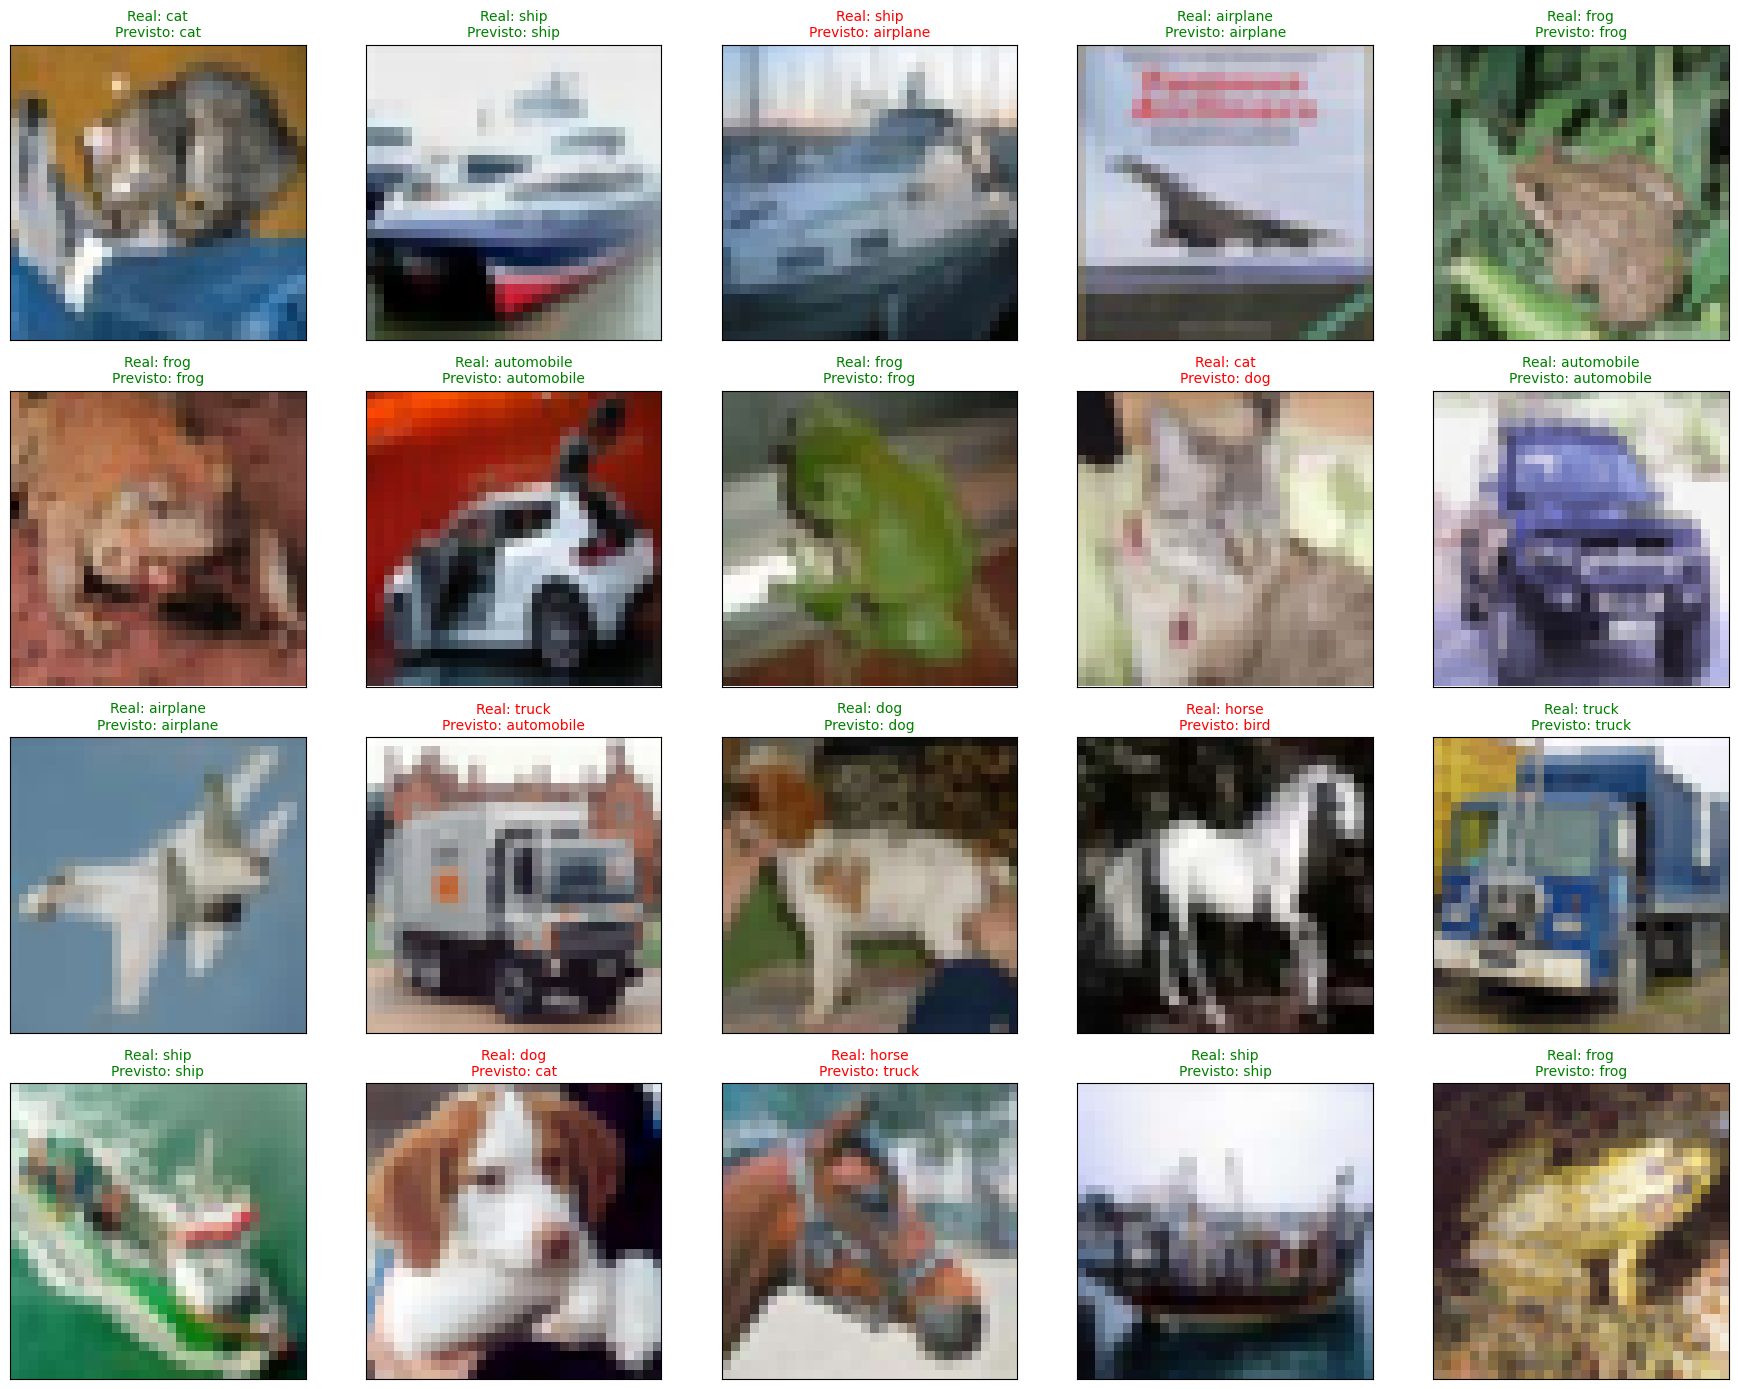

In [ ]:

best_model.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    flattened_images = images.view(images.size(0), -1)

    outputs = best_model(flattened_images)
    _, predicted = torch.max(outputs, 1)


classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

num_images_to_show = 20

fig, axes = plt.subplots(4, 5, figsize=(18, 14))

for i in range(num_images_to_show):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    image_display = images[i].cpu() / 2 + 0.5
    np_image = image_display.numpy()

    true_label = classes[labels[i].cpu().item()]
    predicted_label = classes[predicted[i].cpu().item()]

    title = f"Real: {true_label}\nPrevisto: {predicted_label}"
    title_color = 'green' if true_label == predicted_label else 'red'

    ax.imshow(np.transpose(np_image, (1, 2, 0)))
    ax.set_title(title, color=title_color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## Experimentos - CNN

Agora prosseguimos para a definição dos hiperparâmetros da CNN.

- **Tamanho da rede (profundidade da CNN)**  
  Representa quantas **camadas convolucionais, de pooling e totalmente conectadas** a rede possui. Redes mais profundas aprendem hierarquias mais complexas de padrões (de bordas simples a estruturas de alto nível), mas exigem mais dados, mais poder computacional e são mais propensas a **overfitting** ou **problemas de gradiente**.    
  → Profundidade demais sem regularização e normalização adequada pode degradar o desempenho.

- **Tamanho da janela de convolução (filtro / kernel size)**  
  Define **a área local da imagem** sobre a qual a convolução é aplicada. Filtros pequenos (ex.: 3×3) capturam detalhes finos e permitem arquiteturas mais profundas; filtros grandes (ex.: 7×7 ou 11×11) capturam contextos mais amplos, mas aumentam o número de parâmetros e o custo de computação.
      

- **Stride (passo da convolução)**  
  Controla **o deslocamento da janela de filtro** ao percorrer a entrada. Strides maiores (ex.: 2) reduzem as dimensões espaciais do mapa de ativação, diminuindo o custo computacional, mas também perdem detalhes. Stride = 1 preserva mais informação espacial.


- **Padding (preenchimento das bordas)**  
  Adiciona **zeros (ou outros valores)** nas bordas da entrada antes da convolução, controlando o tamanho do mapa de saída. Padding = “same” mantém a mesma dimensão espacial, enquanto sem padding (“valid”) reduz o tamanho.  
   
  → Padding adequado evita perda de informações nas bordas e preserva alinhamento entre camadas.

- **Dropout**  
  Similar ao MLP, **desativa aleatoriamente neurônios durante o treino**, mas em CNNs costuma ser aplicado nas **camadas totalmente conectadas** do final ou entre blocos convolucionais. Ajuda a evitar overfitting e melhora a robustez do modelo.  
    
  → Dropout excessivo pode prejudicar a convergência.

- **Janela de pooling (pool size)**  
  Define o tamanho da região sobre a qual se aplica o **pooling** (ex.: `MaxPool2d` ou `AvgPool2d`). O pooling reduz a resolução espacial, tornando a rede mais invariante a pequenas translações.  
    
  → Poolings muito agressivos (janela grande) podem destruir detalhes importantes; pequenas (2×2) são preferidas para equilíbrio entre invariância e preservação de informação.

- **Taxa de aprendizagem (learning rate)**  
  Hiperparâmetro crítico também nas CNNs. Determina o tamanho dos passos de atualização dos pesos. Uma **taxa muito alta** pode causar divergência; uma **muito baixa** leva a convergência lenta. CNNs frequentemente se beneficiam de **agendamentos dinâmicos** (ex.: `torch.optim.lr_scheduler.StepLR`, `CosineAnnealingLR`) para reduzir a taxa ao longo do treino.

Experimento 1

- **Tamanho da rede (profundidade):**  
  2 camadas convolucionais + 2 camadas totalmente conectadas.  
  *(Conv1 (3→32), Conv2 (32→64), Linear(64×8×8 → 512), Linear(512 → 10))*

- **Tamanho do kernel (janela de convolução):**  
  `3 × 3` — utilizado em ambas as camadas convolucionais.

- **Stride (passo da convolução):**  
  `1` — valor padrão do `nn.Conv2d` quando não especificado.

- **Padding (preenchimento das bordas):**  
  `1` — mantém a dimensão espacial após a convolução.

- **Dropout:**  
  `0.5` — aplicado na camada totalmente conectada antes da saída.

- **Janela de pooling (pool size):**  
  `2 × 2` — utilizada em ambas as camadas de pooling (`MaxPool2d(kernel_size=2, stride=2)`).

- **Taxa de aprendizagem (learning rate):**  
  `0.001` — definida ao criar o otimizador Adam.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.classifier(x)
        return x

def get_scores1(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

num_classes = 10
learning_rate = 0.001
num_epochs = 20
weight_decay = 1e-4
model = CNN(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
patience = 5
patience_counter = 0
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Treino]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validação]")
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} -> Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping ativado! 🛑")
            break

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        _, predicted = torch.max(output, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores1(true_labels, predictions)
print("\n--- Resultados Finais no Conjunto de Teste ---")
for score_name, score_value in scores.items():
    print(f"{score_name.replace('_', ' ').capitalize()}: {score_value:.4f}")

Epoch 1/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 61.32it/s, val_loss=1.09]


Epoch 1 -> Perda de Treino: 1.5260, Perda de Validação: 1.1701


Epoch 2/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.20it/s, val_loss=0.909]


Epoch 2 -> Perda de Treino: 1.1874, Perda de Validação: 1.0155


Epoch 3/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.78it/s, val_loss=0.882]


Epoch 3 -> Perda de Treino: 1.0668, Perda de Validação: 0.9467


Epoch 4/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.28it/s, val_loss=0.796]


Epoch 4 -> Perda de Treino: 0.9813, Perda de Validação: 0.8690


Epoch 5/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 55.56it/s, val_loss=0.867]


Epoch 5 -> Perda de Treino: 0.9180, Perda de Validação: 0.8415


Epoch 6/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 45.81it/s, val_loss=0.727]


Epoch 6 -> Perda de Treino: 0.8608, Perda de Validação: 0.8203


Epoch 7/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.97it/s, val_loss=0.728]


Epoch 7 -> Perda de Treino: 0.8160, Perda de Validação: 0.7984


Epoch 8/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.92it/s, val_loss=0.938]


Epoch 8 -> Perda de Treino: 0.7715, Perda de Validação: 0.7704


Epoch 9/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 50.16it/s, val_loss=0.558]


Epoch 9 -> Perda de Treino: 0.7292, Perda de Validação: 0.7752


Epoch 10/20 [Validação]: 100%|██████████| 157/157 [00:05<00:00, 29.51it/s, val_loss=0.708]


Epoch 10 -> Perda de Treino: 0.6975, Perda de Validação: 0.7518


Epoch 11/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 61.91it/s, val_loss=0.831]


Epoch 11 -> Perda de Treino: 0.6641, Perda de Validação: 0.7410


Epoch 12/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 48.95it/s, val_loss=0.639]


Epoch 12 -> Perda de Treino: 0.6320, Perda de Validação: 0.7395


Epoch 13/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 48.26it/s, val_loss=0.583]


Epoch 13 -> Perda de Treino: 0.5933, Perda de Validação: 0.7332


Epoch 14/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.65it/s, val_loss=0.677]


Epoch 14 -> Perda de Treino: 0.5680, Perda de Validação: 0.7295


Epoch 15/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 54.86it/s, val_loss=0.596]


Epoch 15 -> Perda de Treino: 0.5474, Perda de Validação: 0.7643


Epoch 16/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.05it/s, val_loss=0.852]


Epoch 16 -> Perda de Treino: 0.5207, Perda de Validação: 0.7494


Epoch 17/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.33it/s, val_loss=0.722]


Epoch 17 -> Perda de Treino: 0.4962, Perda de Validação: 0.7752


Epoch 18/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 57.14it/s, val_loss=0.747]


Epoch 18 -> Perda de Treino: 0.4765, Perda de Validação: 0.7987


Epoch 19/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 45.03it/s, val_loss=1.04]

Epoch 19 -> Perda de Treino: 0.4578, Perda de Validação: 0.8071
Early stopping ativado! 🛑



--- Resultados Finais no Conjunto de Teste ---
Accuracy: 0.7486
Balanced accuracy: 0.7486
Precision: 0.7565
Recall: 0.7486
F1 score: 0.7500


Experimento 2

- **Tamanho da rede (profundidade):**  
  1 camada convolucional + 2 camadas totalmente conectadas.  
  *(Conv1 (3→32), Linear(32×16×16 → 256), Linear(256 → 10))*

- **Tamanho do kernel (janela de convolução):**  
  `5 × 5` — melhora a captura de padrões maiores.

- **Stride (passo da convolução):**  
  `1`

- **Padding (preenchimento das bordas):**  
  `2` — preserva dimensões ao usar kernel 5×5.

- **Dropout:**  
  `0.3` — menos agressivo, útil para redes pequenas.

- **Janela de pooling (pool size):**  
  `2 × 2`

- **Taxa de aprendizagem (learning rate):**  
  `0.0005` — aprendizado mais suave para estabilidade.

In [ ]:
class CNN_Experiment2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Experiment2, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.classifier(x)
        return x

num_classes = 10
learning_rate = 0.0005
num_epochs = 20
weight_decay = 1e-4

model = CNN_Experiment2(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
patience = 5
patience_counter = 0
best_val_loss = float('inf')

print("--- Iniciando Experimento 2 ---")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Treino]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validação]")
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': loss.item()})
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} -> Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping ativado! 🛑")
            break

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores1(true_labels, predictions)
print("\n--- Resultados Finais no Conjunto de Teste (Experimento 2) ---")
for score_name, score_value in scores.items():
    print(f"{score_name.replace('_', ' ').capitalize()}: {score_value:.4f}")

--- Iniciando Experimento 2 ---


Epoch 1/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.84it/s, val_loss=1.43]


Epoch 1 -> Perda de Treino: 1.5797, Perda de Validação: 1.3414


Epoch 2/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.32it/s, val_loss=1.22]


Epoch 2 -> Perda de Treino: 1.3023, Perda de Validação: 1.1810


Epoch 3/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 65.01it/s, val_loss=1.38]


Epoch 3 -> Perda de Treino: 1.1736, Perda de Validação: 1.1082


Epoch 4/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.40it/s, val_loss=1.3]


Epoch 4 -> Perda de Treino: 1.0785, Perda de Validação: 1.0981


Epoch 5/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 50.05it/s, val_loss=1.01]


Epoch 5 -> Perda de Treino: 1.0029, Perda de Validação: 1.0165


Epoch 6/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 55.44it/s, val_loss=0.954]


Epoch 6 -> Perda de Treino: 0.9517, Perda de Validação: 0.9996


Epoch 7/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.66it/s, val_loss=1.14]


Epoch 7 -> Perda de Treino: 0.8979, Perda de Validação: 1.0009


Epoch 8/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.32it/s, val_loss=1.12]


Epoch 8 -> Perda de Treino: 0.8513, Perda de Validação: 0.9832


Epoch 9/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.26it/s, val_loss=0.852]


Epoch 9 -> Perda de Treino: 0.8171, Perda de Validação: 0.9829


Epoch 10/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.39it/s, val_loss=1.12]


Epoch 10 -> Perda de Treino: 0.7702, Perda de Validação: 0.9854


Epoch 11/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.76it/s, val_loss=1.08]


Epoch 11 -> Perda de Treino: 0.7449, Perda de Validação: 1.0019


Epoch 12/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.30it/s, val_loss=0.915]


Epoch 12 -> Perda de Treino: 0.7069, Perda de Validação: 1.0185


Epoch 13/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 47.16it/s, val_loss=1.11]


Epoch 13 -> Perda de Treino: 0.6758, Perda de Validação: 0.9937


Epoch 14/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 46.19it/s, val_loss=0.941]

Epoch 14 -> Perda de Treino: 0.6516, Perda de Validação: 0.9982
Early stopping ativado! 🛑



--- Resultados Finais no Conjunto de Teste (Experimento 2) ---
Accuracy: 0.6705
Balanced accuracy: 0.6705
Precision: 0.6732
Recall: 0.6705
F1 score: 0.6703


Experimento 3

- **Tamanho da rede (profundidade):**  
  4 camadas convolucionais + 2 camadas totalmente conectadas.  
  *(Conv1 (3→64), Conv2 (64→128), Conv3 (128→256), Conv4 (256→256), Linear(256×8×8 → 512), Linear(512 → 10))*

- **Tamanho do kernel (janela de convolução):**  
  `3 × 3`

- **Stride (passo da convolução):**  
  `2`

- **Padding (preenchimento das bordas):**  
  `1`

- **Dropout:**  
  `0.6` — forte regularização para evitar overfitting.

- **Janela de pooling (pool size):**  
  `2 × 2` — após cada duas camadas convolucionais.

- **Taxa de aprendizagem (learning rate):**  
  `0.0001` — taxa mais baixa, indicada para redes profundas.

In [ ]:
class CNN_Experiment3(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Experiment3, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

num_classes = 10
learning_rate = 0.0001
num_epochs = 20
weight_decay = 1e-4

model = CNN_Experiment3(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
patience = 5
patience_counter = 0
best_val_loss = float('inf')

print("--- Iniciando Experimento 3 ---")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Treino]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validação]")
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': loss.item()})
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} -> Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping ativado! 🛑")
            break

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores1(true_labels, predictions)
print("\n--- Resultados Finais no Conjunto de Teste (Experimento 3) ---")
for score_name, score_value in scores.items():
    print(f"{score_name.replace('_', ' ').capitalize()}: {score_value:.4f}")

--- Iniciando Experimento 3 ---


Epoch 1/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 50.39it/s, val_loss=1.18]


Epoch 1 -> Perda de Treino: 1.4631, Perda de Validação: 1.1187


Epoch 2/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 52.10it/s, val_loss=0.819]


Epoch 2 -> Perda de Treino: 1.0527, Perda de Validação: 0.8594


Epoch 3/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 53.96it/s, val_loss=0.594]


Epoch 3 -> Perda de Treino: 0.8935, Perda de Validação: 0.7780


Epoch 4/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 50.13it/s, val_loss=0.766]


Epoch 4 -> Perda de Treino: 0.7948, Perda de Validação: 0.7175


Epoch 5/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.12it/s, val_loss=0.846]


Epoch 5 -> Perda de Treino: 0.7190, Perda de Validação: 0.6970


Epoch 6/20 [Validação]: 100%|██████████| 157/157 [00:04<00:00, 39.07it/s, val_loss=0.862]


Epoch 6 -> Perda de Treino: 0.6635, Perda de Validação: 0.7465


Epoch 7/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 57.27it/s, val_loss=0.571]


Epoch 7 -> Perda de Treino: 0.6060, Perda de Validação: 0.6399


Epoch 8/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 54.91it/s, val_loss=0.596]


Epoch 8 -> Perda de Treino: 0.5565, Perda de Validação: 0.6292


Epoch 9/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 44.31it/s, val_loss=0.604]


Epoch 9 -> Perda de Treino: 0.5152, Perda de Validação: 0.6383


Epoch 10/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 55.87it/s, val_loss=0.423]


Epoch 10 -> Perda de Treino: 0.4726, Perda de Validação: 0.6107


Epoch 11/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 53.18it/s, val_loss=0.617]


Epoch 11 -> Perda de Treino: 0.4319, Perda de Validação: 0.6784


Epoch 12/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 44.34it/s, val_loss=0.735]


Epoch 12 -> Perda de Treino: 0.3987, Perda de Validação: 0.5887


Epoch 13/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 57.67it/s, val_loss=0.493]


Epoch 13 -> Perda de Treino: 0.3695, Perda de Validação: 0.5896


Epoch 14/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.16it/s, val_loss=0.515]


Epoch 14 -> Perda de Treino: 0.3401, Perda de Validação: 0.6028


Epoch 15/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 44.39it/s, val_loss=0.443]


Epoch 15 -> Perda de Treino: 0.3089, Perda de Validação: 0.5571


Epoch 16/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 57.21it/s, val_loss=0.613]


Epoch 16 -> Perda de Treino: 0.2760, Perda de Validação: 0.5725


Epoch 17/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.52it/s, val_loss=0.672]


Epoch 17 -> Perda de Treino: 0.2577, Perda de Validação: 0.5816


Epoch 18/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 50.31it/s, val_loss=0.408]


Epoch 18 -> Perda de Treino: 0.2326, Perda de Validação: 0.5773


Epoch 19/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.05it/s, val_loss=0.403]


Epoch 19 -> Perda de Treino: 0.2201, Perda de Validação: 0.5707


Epoch 20/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 57.10it/s, val_loss=0.834]

Epoch 20 -> Perda de Treino: 0.1978, Perda de Validação: 0.7345
Early stopping ativado! 🛑



--- Resultados Finais no Conjunto de Teste (Experimento 3) ---
Accuracy: 0.7936
Balanced accuracy: 0.7936
Precision: 0.8098
Recall: 0.7936
F1 score: 0.7947


Experimento 4

- **Tamanho da rede (profundidade):**  
  6 camadas convolucionais + 3 camadas totalmente conectadas.  
  *(Conv1 (3→64), Conv2 (64→64), Conv3 (64→128), Conv4 (128→128), Conv5(128→256), Conv6 (256→256), Linear(256×4×4 → 1024), Linear(1024 → 256), Linear(256 → 10))*

- **Tamanho do kernel (janela de convolução):**  
  `3 × 3`

- **Stride (passo da convolução):**  
  `2`

- **Padding (preenchimento das bordas):**  
  `1`

- **Dropout:**  
  `0.5` — aplicado entre as camadas totalmente conectadas.

- **Janela de pooling (pool size):**  
  `2 × 2` — após cada par de convoluções.

- **Taxa de aprendizagem (learning rate):**  
  `0.0002` — comum em redes VGG-like com Adam.

In [ ]:
class CNN_Experiment4(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Experiment4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = 10
learning_rate = 0.0002
num_epochs = 20
weight_decay = 1e-4

model = CNN_Experiment4(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
patience = 5
patience_counter = 0
best_val_loss = float('inf')

print("--- Iniciando Experimento 4 ---")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Treino]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validação]")
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': loss.item()})
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} -> Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping ativado! 🛑")
            break

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores1(true_labels, predictions)
print("\n--- Resultados Finais no Conjunto de Teste (Experimento 4) ---")
for score_name, score_value in scores.items():
    print(f"{score_name.replace('_', ' ').capitalize()}: {score_value:.4f}")

--- Iniciando Experimento 4 ---


Epoch 1/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.04it/s, val_loss=0.802]


Epoch 1 -> Perda de Treino: 1.4414, Perda de Validação: 1.2574


Epoch 2/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.42it/s, val_loss=0.778]


Epoch 2 -> Perda de Treino: 0.9520, Perda de Validação: 0.9378


Epoch 3/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.82it/s, val_loss=0.895]


Epoch 3 -> Perda de Treino: 0.7547, Perda de Validação: 0.8497


Epoch 4/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.83it/s, val_loss=0.614]


Epoch 4 -> Perda de Treino: 0.6269, Perda de Validação: 0.6880


Epoch 5/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.06it/s, val_loss=0.558]


Epoch 5 -> Perda de Treino: 0.5397, Perda de Validação: 0.6407


Epoch 6/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 49.15it/s, val_loss=0.694]


Epoch 6 -> Perda de Treino: 0.4650, Perda de Validação: 0.6707


Epoch 7/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.34it/s, val_loss=0.701]


Epoch 7 -> Perda de Treino: 0.3997, Perda de Validação: 0.5870


Epoch 8/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.27it/s, val_loss=0.665]


Epoch 8 -> Perda de Treino: 0.3454, Perda de Validação: 0.6902


Epoch 9/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 53.68it/s, val_loss=0.469]


Epoch 9 -> Perda de Treino: 0.2945, Perda de Validação: 0.5729


Epoch 10/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.48it/s, val_loss=0.474]


Epoch 10 -> Perda de Treino: 0.2559, Perda de Validação: 0.5630


Epoch 11/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 51.00it/s, val_loss=0.71]


Epoch 11 -> Perda de Treino: 0.2190, Perda de Validação: 0.6811


Epoch 12/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.91it/s, val_loss=0.755]


Epoch 12 -> Perda de Treino: 0.1904, Perda de Validação: 0.6241


Epoch 13/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.62it/s, val_loss=0.616]


Epoch 13 -> Perda de Treino: 0.1687, Perda de Validação: 0.6531


Epoch 14/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.58it/s, val_loss=0.653]


Epoch 14 -> Perda de Treino: 0.1472, Perda de Validação: 0.6389


Epoch 15/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 60.24it/s, val_loss=0.865]


Epoch 15 -> Perda de Treino: 0.1331, Perda de Validação: 0.8530
Early stopping ativado! 🛑

--- Resultados Finais no Conjunto de Teste (Experimento 4) ---
Accuracy: 0.7953
Balanced accuracy: 0.7953
Precision: 0.8246
Recall: 0.7953
F1 score: 0.7967


Experimento 5

- **Tamanho da rede (profundidade):**  
  2 camadas convolucionais + 1 camada totalmente conectada.  
  *(Conv1 (3→32), Conv2 (32→64), Linear(64×8×8 → 10))*

- **Tamanho do kernel (janela de convolução):**  
  `3 × 3`

- **Stride (passo da convolução):**  
  `2` — reduz rapidamente as dimensões espaciais.

- **Padding (preenchimento das bordas):**  
  `1`

- **Dropout:**  
  `0.4`

- **Janela de pooling (pool size):**  
  `2 × 2`

- **Taxa de aprendizagem (learning rate):**  
  `0.005` — mais alta para acelerar o aprendizado inicial.

In [ ]:
class CNN_Experiment5(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Experiment5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64 * 8 * 8, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = 10
learning_rate = 0.005
num_epochs = 20
weight_decay = 1e-4

model = CNN_Experiment5(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
patience = 5
patience_counter = 0
best_val_loss = float('inf')

print("--- Iniciando Experimento 5 ---")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Treino]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validação]")
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': loss.item()})
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} -> Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping ativado! 🛑")
            break

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores1(true_labels, predictions)
print("\n--- Resultados Finais no Conjunto de Teste (Experimento 5) ---")
for score_name, score_value in scores.items():
    print(f"{score_name.replace('_', ' ').capitalize()}: {score_value:.4f}")

--- Iniciando Experimento 5 ---


Epoch 1/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.27it/s, val_loss=0.979]


Epoch 1 -> Perda de Treino: 1.4765, Perda de Validação: 1.1544


Epoch 2/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.02it/s, val_loss=0.818]


Epoch 2 -> Perda de Treino: 1.1188, Perda de Validação: 1.0179


Epoch 3/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 60.29it/s, val_loss=0.872]


Epoch 3 -> Perda de Treino: 1.0157, Perda de Validação: 0.9755


Epoch 4/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 50.09it/s, val_loss=0.92]


Epoch 4 -> Perda de Treino: 0.9580, Perda de Validação: 0.9176


Epoch 5/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 46.89it/s, val_loss=1.02]


Epoch 5 -> Perda de Treino: 0.9139, Perda de Validação: 0.9648


Epoch 6/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 53.71it/s, val_loss=0.796]


Epoch 6 -> Perda de Treino: 0.8835, Perda de Validação: 0.9242


Epoch 7/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.96it/s, val_loss=0.624]


Epoch 7 -> Perda de Treino: 0.8622, Perda de Validação: 0.9004


Epoch 8/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 65.00it/s, val_loss=0.708]


Epoch 8 -> Perda de Treino: 0.8368, Perda de Validação: 0.8659


Epoch 9/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 61.97it/s, val_loss=0.816]


Epoch 9 -> Perda de Treino: 0.8204, Perda de Validação: 0.9237


Epoch 10/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.62it/s, val_loss=0.784]


Epoch 10 -> Perda de Treino: 0.8105, Perda de Validação: 0.9056


Epoch 11/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.62it/s, val_loss=0.934]


Epoch 11 -> Perda de Treino: 0.8028, Perda de Validação: 0.8914


Epoch 12/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 62.83it/s, val_loss=0.647]


Epoch 12 -> Perda de Treino: 0.7828, Perda de Validação: 0.8432


Epoch 13/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 64.75it/s, val_loss=0.593]


Epoch 13 -> Perda de Treino: 0.7707, Perda de Validação: 0.8661


Epoch 14/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.13it/s, val_loss=0.817]


Epoch 14 -> Perda de Treino: 0.7690, Perda de Validação: 0.8499


Epoch 15/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 45.58it/s, val_loss=0.766]


Epoch 15 -> Perda de Treino: 0.7559, Perda de Validação: 0.8779


Epoch 16/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 52.49it/s, val_loss=0.71]


Epoch 16 -> Perda de Treino: 0.7477, Perda de Validação: 0.8465


Epoch 17/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 63.93it/s, val_loss=0.676]

Epoch 17 -> Perda de Treino: 0.7408, Perda de Validação: 0.8612
Early stopping ativado! 🛑



--- Resultados Finais no Conjunto de Teste (Experimento 5) ---
Accuracy: 0.7056
Balanced accuracy: 0.7056
Precision: 0.7058
Recall: 0.7056
F1 score: 0.7007


Experimento 6

- **Tamanho da rede (profundidade):**  
  3 camadas convolucionais + 2 camadas totalmente conectadas.  
  *(Conv1 (3→32), Conv2 (32→64), Conv3 (64→128), Linear(128×4×4 → 256), Linear(256 → 10))*

- **Tamanho do kernel (janela de convolução):**  
  `7 × 7` na primeira camada, `5 × 5` e `3 × 3` nas seguintes.

- **Stride (passo da convolução):**  
  `1`

- **Padding (preenchimento das bordas):**  
  Ajustado para cada kernel (`3`, `2`, `1` respectivamente).

- **Dropout:**  
  `0.5`

- **Janela de pooling (pool size):**  
  `AdaptiveAvgPool2d((4,4))` — ajusta automaticamente o tamanho final do mapa de ativação.

- **Taxa de aprendizagem (learning rate):**  
  `0.0008`

In [ ]:
class CNN_Experiment6(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Experiment6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = 10
learning_rate = 0.0008
num_epochs = 20
weight_decay = 1e-4

model = CNN_Experiment6(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
patience = 5
patience_counter = 0
best_val_loss = float('inf')

print("--- Iniciando Experimento 6 ---")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Treino]")
    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validação]")
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': loss.item()})
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} -> Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping ativado! 🛑")
            break

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

scores = get_scores1(true_labels, predictions)
print("\n--- Resultados Finais no Conjunto de Teste (Experimento 6) ---")
for score_name, score_value in scores.items():
    print(f"{score_name.replace('_', ' ').capitalize()}: {score_value:.4f}")

--- Iniciando Experimento 6 ---


Epoch 1/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 60.24it/s, val_loss=1.1]


Epoch 1 -> Perda de Treino: 1.5233, Perda de Validação: 1.2272


Epoch 2/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 60.06it/s, val_loss=0.756]


Epoch 2 -> Perda de Treino: 1.2066, Perda de Validação: 1.0709


Epoch 3/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 47.76it/s, val_loss=0.687]


Epoch 3 -> Perda de Treino: 1.0681, Perda de Validação: 0.9599


Epoch 4/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.97it/s, val_loss=0.57]


Epoch 4 -> Perda de Treino: 0.9822, Perda de Validação: 0.8955


Epoch 5/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 60.25it/s, val_loss=0.545]


Epoch 5 -> Perda de Treino: 0.9121, Perda de Validação: 0.8178


Epoch 6/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.20it/s, val_loss=0.689]


Epoch 6 -> Perda de Treino: 0.8602, Perda de Validação: 0.7867


Epoch 7/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.88it/s, val_loss=0.572]


Epoch 7 -> Perda de Treino: 0.8200, Perda de Validação: 0.7632


Epoch 8/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.52it/s, val_loss=0.57]


Epoch 8 -> Perda de Treino: 0.7853, Perda de Validação: 0.7463


Epoch 9/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.83it/s, val_loss=0.523]


Epoch 9 -> Perda de Treino: 0.7535, Perda de Validação: 0.7511


Epoch 10/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.61it/s, val_loss=0.591]


Epoch 10 -> Perda de Treino: 0.7181, Perda de Validação: 0.7307


Epoch 11/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.42it/s, val_loss=0.502]


Epoch 11 -> Perda de Treino: 0.6945, Perda de Validação: 0.7383


Epoch 12/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.46it/s, val_loss=0.572]


Epoch 12 -> Perda de Treino: 0.6723, Perda de Validação: 0.6816


Epoch 13/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.08it/s, val_loss=0.487]


Epoch 13 -> Perda de Treino: 0.6481, Perda de Validação: 0.6865


Epoch 14/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.74it/s, val_loss=0.483]


Epoch 14 -> Perda de Treino: 0.6231, Perda de Validação: 0.6544


Epoch 15/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 46.06it/s, val_loss=0.518]


Epoch 15 -> Perda de Treino: 0.6043, Perda de Validação: 0.7027


Epoch 16/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.71it/s, val_loss=0.636]


Epoch 16 -> Perda de Treino: 0.5813, Perda de Validação: 0.6641


Epoch 17/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 59.09it/s, val_loss=0.794]


Epoch 17 -> Perda de Treino: 0.5580, Perda de Validação: 0.6666


Epoch 18/20 [Validação]: 100%|██████████| 157/157 [00:03<00:00, 43.18it/s, val_loss=0.676]


Epoch 18 -> Perda de Treino: 0.5449, Perda de Validação: 0.7087


Epoch 19/20 [Validação]: 100%|██████████| 157/157 [00:02<00:00, 58.60it/s, val_loss=0.687]

Epoch 19 -> Perda de Treino: 0.5272, Perda de Validação: 0.6590
Early stopping ativado! 🛑



--- Resultados Finais no Conjunto de Teste (Experimento 6) ---
Accuracy: 0.7697
Balanced accuracy: 0.7697
Precision: 0.7792
Recall: 0.7697
F1 score: 0.7689


## Otimização de Hiperparâmetros com Optuna - CNN

Da mesma maneira que fizemos com o MLP, vamos utilizar do Optuna para validação e encontrar o melhor modelo variando os hiperparâmetros:

- **Tamanho da rede (profundidade da CNN):** de 2 a 6 camadas. Cada camada com convolução, batchnorm, ReLU e MaxPool.

- **Tamanho da janela de convolução (filtro / kernel size):** 3x3, 4x4 ou 5x5.

- **Stride (passo da convolução):** 1 ou 2.

- **Padding (preenchimento das bordas):** 0, 1 ou 2.

- **Dropout:** de 0.1 a 0.5.

- **Janela de pooling (pool size):** 2x2 ou 3x3.

- **Taxa de aprendizagem (learning rate):** de 1e-5 a 1e-2.

- **Optimizer:** Adam, SGD ou RMSprop.

In [ ]:
def objectiveCNN(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 6)
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    stride = trial.suggest_int('stride', 1, 2)
    padding = trial.suggest_int('padding', 0, 2)
    pool_size = trial.suggest_categorical('pool_size', [2, 3])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    layers = []
    in_channels = 3

    try:
        out_channels = trial.suggest_int('out_channels_1', 16, 128)
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(pool_size))

        for i in range(1, n_conv_layers):
            in_channels = out_channels
            out_channels = trial.suggest_int(f'out_channels_{i+1}', 16, 256)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(pool_size))

        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Flatten())

        dummy_input = torch.zeros((1, 3, 32, 32))
        with torch.no_grad():
            dummy_model = nn.Sequential(*layers)
            dummy_out = dummy_model(dummy_input)
            flatten_dim = dummy_out.shape[1]

        layers.append(nn.Linear(flatten_dim, 128))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(128, 10))

    except (RuntimeError, ValueError) as e:
        print(f"Trial podado devido a uma arquitetura inválida: {e}")
        raise optuna.exceptions.TrialPruned()

    model = nn.Sequential(*layers).to(device)

    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
studyCNN = optuna.create_study(direction='maximize')
studyCNN.optimize(objectiveCNN, n_trials=50, show_progress_bar=True)

print("\n--- Resultado da Otimização ---")
print("Melhores hiperparâmetros: ", studyCNN.best_params)
print("Melhor acurácia de validação: {:.4f}".format(studyCNN.best_value))

[I 2025-10-08 17:56:27,049] A new study created in memory with name: no-name-a920df66-36c0-4d82-871c-2f7d2874d5e6


  0%|          | 0/50 [00:00<?, ?it/s]

Trial podado devido a uma arquitetura inválida: Calculated padded input size per channel: (1 x 1). Kernel size: (5 x 5). Kernel size can't be greater than actual input size
[I 2025-10-08 17:56:27,098] Trial 0 pruned. 
Trial podado devido a uma arquitetura inválida: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size
[I 2025-10-08 17:56:27,103] Trial 1 pruned. 
Trial podado devido a uma arquitetura inválida: Calculated padded input size per channel: (1 x 1). Kernel size: (5 x 5). Kernel size can't be greater than actual input size
[I 2025-10-08 17:56:27,115] Trial 2 pruned. 
[I 2025-10-08 17:58:21,561] Trial 3 finished with value: 0.6684 and parameters: {'n_conv_layers': 5, 'kernel_size': 3, 'stride': 1, 'padding': 2, 'pool_size': 3, 'dropout_rate': 0.1330638461804962, 'learning_rate': 0.00633211000900866, 'out_channels_1': 73, 'out_channels_2': 206, 'out_channels_3': 152, 'out_channels_4': 206, 'out_channels_5': 8

In [ ]:
vis.plot_optimization_history(studyCNN).show()

In [ ]:

vis.plot_param_importances(studyCNN).show()
for p in studyCNN.best_params.keys():
    fig = vis.plot_slice(studyCNN, params=[p])
    fig.show()

## Avaliação Final do Melhor Modelo (Optuna) - CNN

In [ ]:
def train_and_evaluateCNN(model, train_loader, test_loader, best_params, n_epochs):
    optimizer = getattr(optim, best_params['optimizer'])(
        model.parameters(),
        lr=best_params['learning_rate']
    )
    criterion = nn.CrossEntropyLoss()

    print(f"\nIniciando treinamento com os melhores hiperparâmetros por {n_epochs} épocas...")
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for i, (data, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n--- Relatório de Classificação Final ---")
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    print(f"Acurácia total: {accuracy:.4f}\n")

    precision, recall, f1, _ = metrics.precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    for i, class_name in enumerate(classes):
        print(f"Classe: {class_name}")
        class_labels = np.array(all_labels)
        class_preds = np.array(all_preds)

        correct_mask = (class_labels == i)
        if np.sum(correct_mask) > 0:
            class_accuracy = metrics.accuracy_score(class_labels[correct_mask], class_preds[correct_mask])
            print(f"  Acurácia: {class_accuracy:.4f}")
        else:
            print(f"  Acurácia: N/A (Sem amostras para esta classe no teste)")

        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}\n")

    precision_macro, recall_macro, f1_macro, _ = metrics.precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    print("--- Métricas totais (Macro-média) ---")
    print(f"Precision total: {precision_macro:.4f}")
    print(f"Recall total: {recall_macro:.4f}")
    print(f"F1-Score total: {f1_macro:.4f}")

best_params = studyCNN.best_params

layers = []
in_channels = 3
out_channels = best_params['out_channels_1']

kernel_size = best_params['kernel_size']
stride = best_params['stride']
padding = best_params['padding']
pool_size = best_params['pool_size']
dropout_rate = best_params['dropout_rate']
n_conv_layers = best_params['n_conv_layers']

layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
layers.append(nn.BatchNorm2d(out_channels))
layers.append(nn.ReLU())
layers.append(nn.MaxPool2d(pool_size))

for i in range(1, n_conv_layers):
    in_channels = out_channels
    out_channels = best_params[f'out_channels_{i+1}']
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(pool_size))

layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Flatten())

dummy_input = torch.zeros((1, 3, 32, 32)).to(device)
with torch.no_grad():
    dummy_model = nn.Sequential(*layers).to(device)
    dummy_out = dummy_model(dummy_input)
    flatten_dim = dummy_out.shape[1]

layers.append(nn.Linear(flatten_dim, 128))
layers.append(nn.ReLU())
layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(128, 10))

best_model = nn.Sequential(*layers).to(device)
print("\n--- Arquitetura do Melhor Modelo ---")
print(best_model)


full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
n_epochs_final = 50
train_and_evaluateCNN(best_model, full_train_loader, test_loader, best_params, n_epochs_final)


--- Arquitetura do Melhor Modelo ---
Sequential(
  (0): Conv2d(3, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(80, 226, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(226, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(226, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(

Epoch 50/50: 100%|██████████| 782/782 [00:19<00:00, 39.73it/s]



--- Relatório de Classificação Final ---
Acurácia total: 0.8271

Classe: plane
  Acurácia: 0.8390
  Precision: 0.8501
  Recall: 0.8390
  F1-Score: 0.8445

Classe: car
  Acurácia: 0.9130
  Precision: 0.9176
  Recall: 0.9130
  F1-Score: 0.9153

Classe: bird
  Acurácia: 0.7240
  Precision: 0.7895
  Recall: 0.7240
  F1-Score: 0.7553

Classe: cat
  Acurácia: 0.6760
  Precision: 0.6898
  Recall: 0.6760
  F1-Score: 0.6828

Classe: deer
  Acurácia: 0.8270
  Precision: 0.7937
  Recall: 0.8270
  F1-Score: 0.8100

Classe: dog
  Acurácia: 0.7230
  Precision: 0.7675
  Recall: 0.7230
  F1-Score: 0.7446

Classe: frog
  Acurácia: 0.9000
  Precision: 0.8249
  Recall: 0.9000
  F1-Score: 0.8608

Classe: horse
  Acurácia: 0.8480
  Precision: 0.8788
  Recall: 0.8480
  F1-Score: 0.8631

Classe: ship
  Acurácia: 0.9270
  Precision: 0.8680
  Recall: 0.9270
  F1-Score: 0.8965

Classe: truck
  Acurácia: 0.8940
  Precision: 0.8825
  Recall: 0.8940
  F1-Score: 0.8882

--- Métricas totais (Macro-média) ---
Precis


--- Visualizando algumas predições do conjunto de teste ---


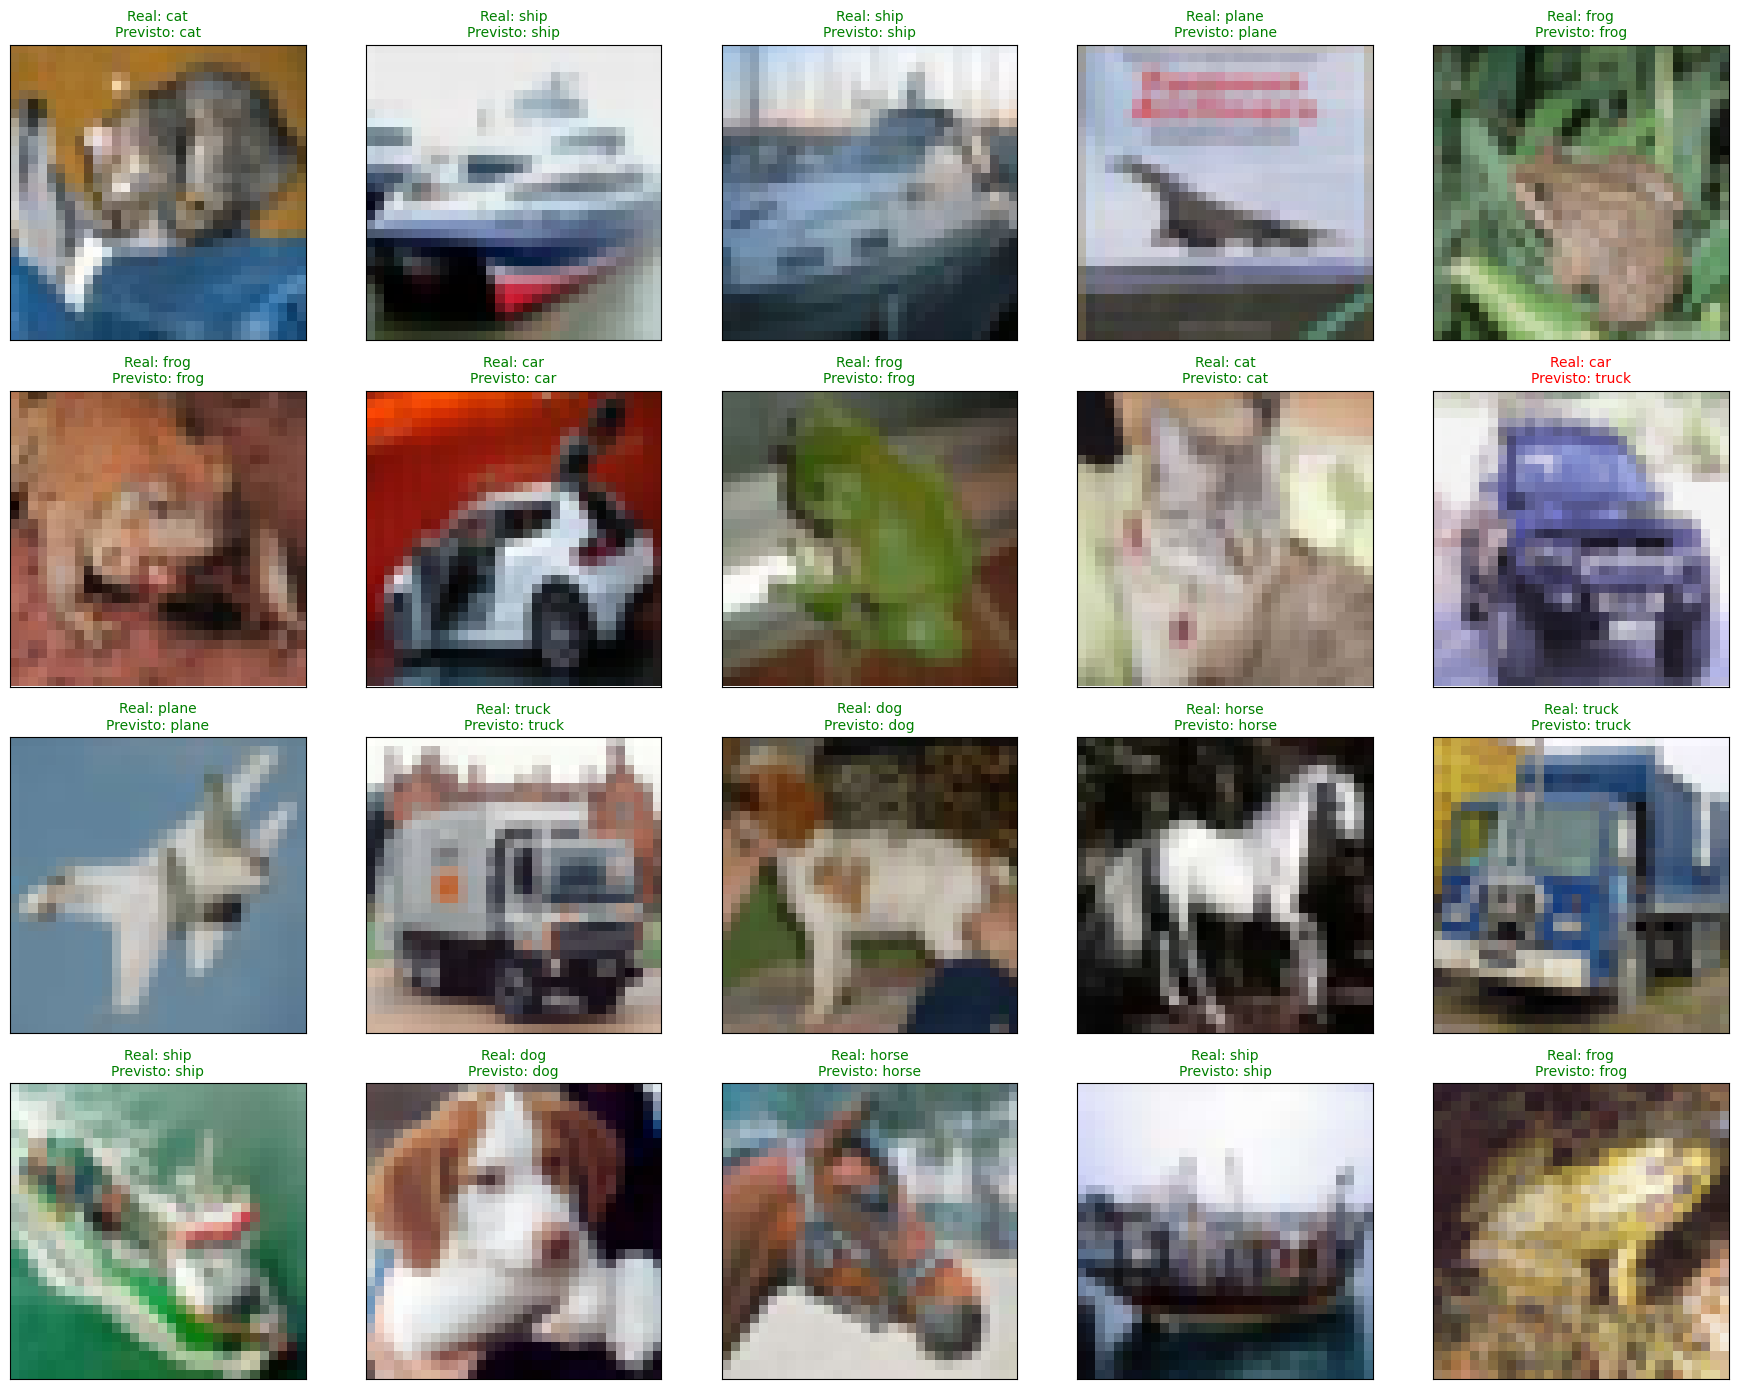

In [ ]:
print("\n--- Visualizando algumas predições do conjunto de teste ---")
best_model.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

num_images_to_show = 20
fig, axes = plt.subplots(4, 5, figsize=(18, 14))

for i in range(num_images_to_show):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    image_display = images[i].cpu() / 2 + 0.5
    np_image = image_display.numpy()

    true_label = classes[labels[i].cpu().item()]
    predicted_label = classes[predicted[i].cpu().item()]

    title = f"Real: {true_label}\nPrevisto: {predicted_label}"
    title_color = 'green' if true_label == predicted_label else 'red'

    ax.imshow(np.transpose(np_image, (1, 2, 0)))
    ax.set_title(title, color=title_color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()